# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import nltk

In [2]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
22297,31038,75990,North Wales,03-04-2020,@asda is it true that you have imported Polish...,Extremely Positive
2605,6949,51901,"Palm Beach, FL",18-03-2020,"Worst of panic buying over, says supply chain ...",Extremely Negative
28806,39146,84098,"Indore, India",09-04-2020,@ssupnow ACROSS ?\r\r\n\r\r\n1?? SANITIZER\r\r...,Extremely Positive
8180,13732,58684,"Toronto, Ontario",20-03-2020,COVID-19 outbreak: Rich buy more and more whil...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,Positive
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,Extremely Positive
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
33442,44953,89905,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,Positive


In [4]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [5]:
df = df.replace(df['Sentiment'].unique(), [1, 0, 0, 1])

Сбалансированы ли классы?

In [6]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [7]:
df[df['Sentiment'] == 1].shape[0] / df.shape[0]

0.5395885659610095

**Ответ:** Положительные ответы составляют почти 54% всех данных, значит классы сбалансированы.


Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [8]:
df[df.isna() == True].columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [10]:
df = df.fillna('Unknown')

In [11]:
df.isna().values.any()

False

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(['Sentiment'], axis=1)
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.seed(42))

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [13]:
allwords = []
for line in X_train['OriginalTweet']:
  for w in line.split():
    allwords.append(w.lower())

In [14]:
all_words = nltk.FreqDist(allwords)

Какой размер словаря получился?

In [15]:
len(all_words)

79513

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [16]:
all_words.most_common(10)

[('the', 26772),
 ('to', 23480),
 ('and', 14566),
 ('of', 13053),
 ('a', 11537),
 ('in', 11201),
 ('for', 8541),
 ('#coronavirus', 8168),
 ('is', 7396),
 ('are', 6898)]

**Ответ:** Потому что на данном этапе мы не убрали стоп-слова из словаря, поэтому самыми часто используемыми словами оказались слова, которые чаще всего используются в английском языке.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [17]:
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)

stop_words = set(stopwords.words('english'))

filtered = [w for w in allwords if not w in stop_words]

all_words = nltk.FreqDist(filtered)
all_words.most_common(10)

[('#coronavirus', 8168),
 ('prices', 3895),
 ('food', 3845),
 ('grocery', 3425),
 ('supermarket', 3278),
 ('covid-19', 3174),
 ('store', 3171),
 ('people', 3142),
 ('#covid19', 2483),
 ('consumer', 2262)]

**Ответ:**  Здесь уже можно увидеть более содержательные слова, напрямую относящиеся к теме коронавируса.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [18]:
all_words.most_common()[-20:]

[('https://t.co/jbykncmrxf', 1),
 ('https://t.co/vsiiwruts7', 1),
 ('https://t.co/f62lteprso', 1),
 ("colombia's", 1),
 ('@mauriciocard', 1),
 ('aq:', 1),
 ('outflows', 1),
 ('"unavoidable"', 1),
 ('https://t.co/x3nflaebnk', 1),
 ('https://t.co/cywvxl4hzx', 1),
 ('.@nclc4consumers', 1),
 ('"surviving', 1),
 ('debt"', 1),
 ('link,', 1),
 ('https://t.co/1whyfial70', 1),
 ('islands,', 1),
 ('https://t.co/1ioo4mlmzc', 1),
 ('enraging!!', 1),
 ('https://t.co/ksnz52unrv', 1),
 ('https://t.co/i2wsgmzxtg', 1)]

**Ответ:** Многие непопулярные токены здесь - это по сути шум: ссылки, отметки людей и тд. Это будет мешать нам в дальнейшем, так что нужно будет их убрать.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [19]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()

tw_words = []
for tweet in X_train['OriginalTweet']:
  for w in tw.tokenize(tweet.lower()):
    tw_words.append(w)

tw_dict = nltk.FreqDist(tw_words)
tw_dict.most_common(10)

[('the', 26956),
 ('.', 23945),
 ('to', 23587),
 (',', 17430),
 ('and', 14709),
 ('of', 13082),
 ('a', 11680),
 ('in', 11342),
 ('?', 9725),
 ('#coronavirus', 8727)]

**Ответ:** Данный токенайзер воспринимает пунктуацию, как отдельные слова, так что они тоже попали в топ-10.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [20]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)

tw_filtered = [w for w in tw_words if not w in noise]

tw_dict = nltk.FreqDist(tw_filtered)
tw_dict.most_common(10)

[('#coronavirus', 8727),
 ('â', 7272),
 ('\x82', 7165),
 ('19', 7146),
 ('covid', 6211),
 ('prices', 4603),
 ('food', 4411),
 ('\x92', 4301),
 ('store', 3862),
 ('supermarket', 3819)]

**Ответ:** Есть странные символы с \х82 и \х92, а также символ, похожий на букву а.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [21]:
tw_filtered = [token for token in tw_filtered if len(token) > 1 or ord(token) < 128]

tw_dict = nltk.FreqDist(tw_filtered)
tw_dict.most_common(10)

[('#coronavirus', 8727),
 ('19', 7146),
 ('covid', 6211),
 ('prices', 4603),
 ('food', 4411),
 ('store', 3862),
 ('supermarket', 3819),
 ('grocery', 3481),
 ('people', 3418),
 ('#covid19', 2593)]

In [22]:
tw_dict.most_common()[-20:]

[('opportunism', 1),
 ('#stopprofiteering', 1),
 ('https://t.co/dhj10u2kso', 1),
 ('hickey', 1),
 ("#al's", 1),
 ("al's", 1),
 ('karwick', 1),
 ('https://t.co/jbykncmrxf', 1),
 ('https://t.co/vsiiwruts7', 1),
 ('https://t.co/f62lteprso', 1),
 ("colombia's", 1),
 ('@mauriciocard', 1),
 ('aq', 1),
 ('outflows', 1),
 ('https://t.co/x3nflaebnk', 1),
 ('https://t.co/cywvxl4hzx', 1),
 ('https://t.co/1whyfial70', 1),
 ('https://t.co/1ioo4mlmzc', 1),
 ('https://t.co/ksnz52unrv', 1),
 ('https://t.co/i2wsgmzxtg', 1)]

**Ответ:** В основном изменились положения слов в топе (их количество в твитах).

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [23]:
hashtags = [ht for ht in tw_filtered if ht[0] == '#']
ht_dict = nltk.FreqDist(hashtags)
ht_dict.most_common(10)

[('#coronavirus', 8727),
 ('#covid19', 2593),
 ('#covid_19', 1724),
 ('#covid2019', 947),
 ('#toiletpaper', 753),
 ('#covid', 636),
 ('#socialdistancing', 468),
 ('#coronacrisis', 446),
 ('#pandemic', 245),
 ('#coronaviruspandemic', 244)]

**Ответ:** Они все напрямую связаны с темой твитов - коронавирусом.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [24]:
links = [link for link in tw_filtered if link[:12] == 'https://t.co']
links_dict = nltk.FreqDist(links)
links_dict.most_common(10)

[('https://t.co/3kfuiojxep', 4),
 ('https://t.co/r7sagojsjg', 4),
 ('https://t.co/wrlhyzizaa', 4),
 ('https://t.co/oi39zsanq8', 3),
 ('https://t.co/gp3eusapl8', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/za8rewpvvb', 3),
 ('https://t.co/6yvykiab2c', 3),
 ('https://t.co/xpcm2xkj4o', 3),
 ('https://t.co/pe99mhrsat', 3)]

**Ответ:** Ссылки встречаются крайне редко и не несут никакой информативной важности для нас.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [25]:
def custom_tokenizer(text):
  tokens = []
  tw = TweetTokenizer()
  noise = stopwords.words("english") + list(punctuation)
  for w in tw.tokenize(text.lower()):
    if (len(w) > 1 or ord(w) < 128) and not w in noise and w[:12] != 'https://t.co':
      tokens.append(w)

  return tokens


In [26]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

cv_train = cv.fit_transform(X_train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45180


In [30]:
cv_train.shape

(23410, 45180)

**Ответ:** Словарь уменьшился почти в 2 раза.

Посмотрим на какой-нибудь конкретный твитт:

In [31]:
ind = 9023
df.iloc[ind]['OriginalTweet'], df.iloc[ind]['Sentiment']

("Shop keepers taking advantage of #Coronavirus boosting prices disproportionately so the most Marginalised suffer who can't afford it #SHAMEONYOU #Wewillremember",
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [41]:
tweet = custom_tokenizer(df.iloc[ind]['OriginalTweet'])
cv_tweet = cv.transform(tweet)

tweet_tokens = cv.get_feature_names_out()

matrix = cv_tweet.toarray()
non_zero = np.nonzero(matrix)[1]
maxx = np.argmax(matrix[:, non_zero])
minn = np.argmin(matrix[:, non_zero])

most = tweet_tokens[non_zero[maxx]]
least = tweet_tokens[non_zero[minn]]

most, least

('shop', 'keepers')

**Ответ:** Они получились достаточно логичными, но текст твита довольно короткий, так что данные токены не являются особо показательными.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer).fit(X_train['OriginalTweet'])
tfidf_tweet = tfidf.transform(tweet)

tweet_tokens = tfidf.get_feature_names_out()

matrix = tfidf_tweet.toarray()
non_zero = np.nonzero(matrix)[1]
maxx = np.argmax(matrix[:, non_zero])
minn = np.argmin(matrix[:, non_zero])

most = tweet_tokens[non_zero[maxx]]
least = tweet_tokens[non_zero[minn]]

most, least

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


('shop', 'keepers')

**Ответ:** Определились такие же токены, что и в CountVectorizer.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [44]:
good_tweet = df[df['OriginalTweet'].apply(lambda x: 'good' in x) & (df['Sentiment'] == 1)].iloc[1, :]['OriginalTweet']
good_tweet

'I love this ?? all grocery stores should have a set hour (preferably in the morning) for the elderly population or those with compromised immune systems to use the store. ThatÃ\x82Â\x92s good, clear thinking.\r\r\n.\r\r\n@brianschatz @maziehirono @NYGovCuomo @GovInslee \r\r\n#COVID?19 #coronavirus https://t.co/TMQH0CSeIN'

In [46]:
good_tweet = custom_tokenizer(good_tweet)
good_tfidf_tweet = tfidf.transform(good_tweet)

good_tweet_tokens = tfidf.get_feature_names_out()

matrix = good_tfidf_tweet.toarray()
maxx = matrix.argmax(axis=1)

most_imp = good_tweet_tokens[maxx[0]]

most_imp

'love'

**Ответ:** Здесь TfidfVectorizer выделил токен love - он полезен в определении окраски, поскольку чаще всего используется в контексте "I love this... / I love how..." и тд.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

cv = CountVectorizer(tokenizer=custom_tokenizer)
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

cv_train = cv.fit_transform(X_train['OriginalTweet'])
tfidf_train = tfidf.fit_transform(X_train['OriginalTweet'])

cv_test = cv.transform(X_test['OriginalTweet'])
tfidf_test = tfidf.transform(X_test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=300)

logreg.fit(cv_train, y_train)
cv_pred = logreg.predict(cv_test)
print(classification_report(y_test, cv_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4615
           1       0.88      0.89      0.88      5419

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [50]:
logreg.fit(tfidf_train, y_train)
tfidf_pred = logreg.predict(tfidf_test)
print(classification_report(y_test, tfidf_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4615
           1       0.85      0.88      0.86      5419

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



**Ответ:** CountVectorizer показал результат лучше, чем TfidfVectorizer, но всего на пару процентов.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [53]:
from nltk.stem import SnowballStemmer

def custom_stem_tokenizer(text):
  tokens = []
  tw = TweetTokenizer()
  stemmer = SnowballStemmer(language='english')
  noise = stopwords.words("english") + list(punctuation)
  for w in tw.tokenize(text.lower()):
    if (len(w) > 1 or ord(w) < 128) and not w in noise and w[:12] != 'https://t.co':
      w = stemmer.stem(w)
      tokens.append(w)

  return tokens

In [54]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [55]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

cv_train_stem = cv.fit_transform(X_train['OriginalTweet'])
tfidf_train_stem = tfidf.fit_transform(X_train['OriginalTweet'])

cv_test_stem = cv.transform(X_test['OriginalTweet'])
tfidf_test_stem = tfidf.transform(X_test['OriginalTweet'])

print(len(cv.vocabulary_))
vocab_length = len(cv.vocabulary_)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36550


**Ответ** Размер словаря сократился на почти 10000 слов.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [56]:
logreg.fit(cv_train_stem, y_train)
cv_pred_stem = logreg.predict(cv_test_stem)
print(classification_report(y_test, cv_pred_stem))

logreg.fit(tfidf_train_stem, y_train)
tfidf_pred_stem = logreg.predict(tfidf_test_stem)
print(classification_report(y_test, tfidf_pred_stem))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4615
           1       0.88      0.89      0.89      5419

    accuracy                           0.88     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.88      0.87     10034

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      4615
           1       0.86      0.89      0.87      5419

    accuracy                           0.86     10034
   macro avg       0.86      0.86      0.86     10034
weighted avg       0.86      0.86      0.86     10034



**Ответ:** Качество немного улучшилось, значит есть смысл применять стемминг. Качество увеличилось в среднем на 1%, и я думаю это связано с тем, что рассматриваемые твиты написаны на английском языке, где не так много разных форм одного слова. Стемминг нужен намного больше, например, в русском языке.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [59]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            X_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36549


In [58]:
max_df = 0.1

while True:
    cv_df1 = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df).fit(X_train['OriginalTweet'])

    if len(cv_df1.vocabulary_) == vocab_length - 1:
        break
    else:
        max_df += 0.1

print(max_df)

0.30000000000000004


**Ответ:** У меня параметр вышел равным 0.3, и я думаю это из-за того, что мы убрали все стоп-слова, так что остались только слова, которые не слишком часто используются, поэтому порог оказался 30%.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [60]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11 #я здесь в итоге вручную нашла просто
                        ).fit(
                            X_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3719


In [62]:
cv_df_train = cv_df.fit_transform(X_train['OriginalTweet'])
cv_df_test = cv_df.transform(X_test['OriginalTweet'])

logreg.fit(cv_df_train, y_train)
cv_df_pred = logreg.predict(cv_df_test)
print(classification_report(y_test, cv_df_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4615
           1       0.88      0.89      0.88      5419

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



**Ответ:** Точность в среднем изменилась меньше, чем на процент, так что качество не ухудшилось.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
sc_train = scaler.fit_transform(cv_df_train)
sc_test = scaler.transform(cv_df_test)

logreg.fit(sc_train, y_train)
sc_pred = logreg.predict(sc_test)
print(classification_report(y_test, sc_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4615
           1       0.86      0.86      0.86      5419

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



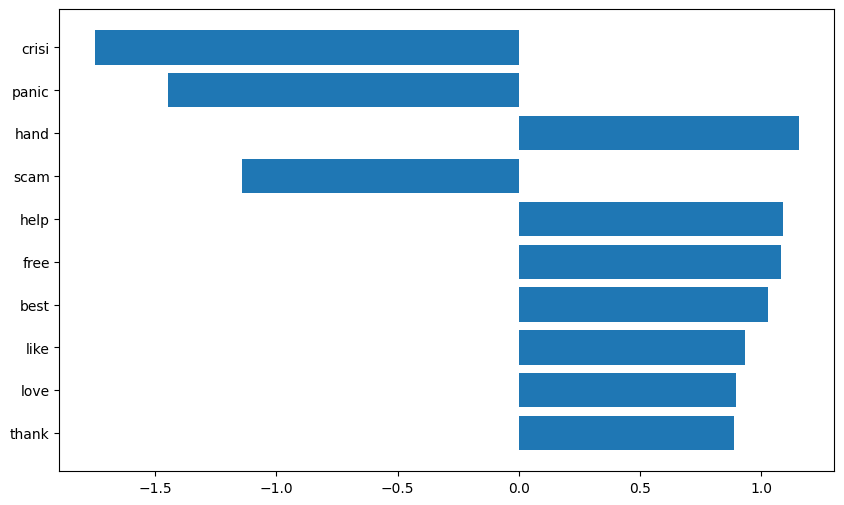

In [68]:
coefs = logreg.coef_[0]
abs_coefs = np.abs(coefs)

tokens = cv_df.get_feature_names_out()

top_inds = np.argsort(abs_coefs)[-10:]
top_tokens = [tokens[i] for i in top_inds]

plt.figure(figsize=(10, 6))
plt.barh(np.arange(10), coefs[top_inds])
plt.yticks(np.arange(10), top_tokens)
plt.show()

**Ответ:** Они очень хорошо отражают настроение твита: по всем этим токенам можно с хорошей точностью предсказать, положительный твит или отрицательный.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [69]:
df.shape

(33444, 6)

In [71]:
df['UserName'].unique().shape[0], df['ScreenName'].unique().shape[0]

(33444, 33444)

**Ответ:** Признаки UserName и ScreenName бесполезны, так как каждое их значение - уникально.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

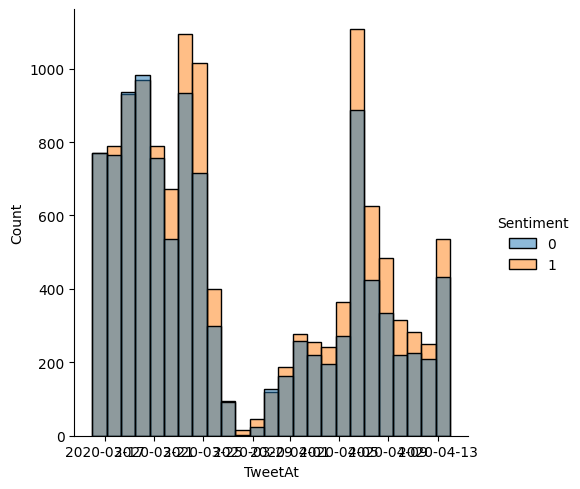

In [72]:
train = X_train
train['Sentiment'] = y_train

train['TweetAt']= pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')

sns.displot(train, x="TweetAt", hue="Sentiment")
plt.show()

**Ответ:** Никакой сильной зависимости на графике не наблюдается, так что данный признак является для нас бесполезным.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [73]:
train['Location'].unique().shape[0]

7883

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

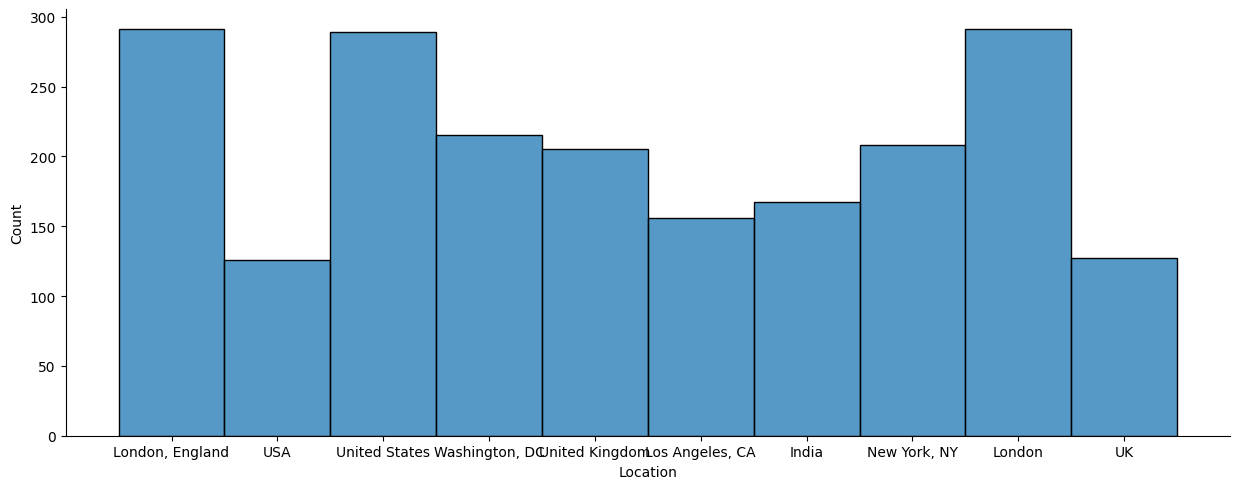

In [74]:
locations = train['Location'].value_counts()[1:11].index.tolist()
train_loc = train[train['Location'].apply(lambda x: x in locations)]

sns.displot(train_loc, x="Location", aspect=2.5)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# -- YOUR CODE HERE --

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --